Implement a simple risk model estimation framework.

# Imports

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as slmode

import core.artificial_signal_generators as carsigen
import core.config as cconfig
import core.features as cofeatur
import core.finance as cofinanc
import core.finance.market_data_example as cfmadaex
import core.signal_processing as csigproc
import dataflow.core as dtfcore
import dataflow.system as dtfsys
import helpers.hdbg as hdbg
import helpers.hprint as hprint

/app/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-352f8814-e59a-4edc-abe8-f56b7fe7240b.json'


# Generate input data

In [3]:
# Assume there are `n` assets
# - Generate returns for the `n` assets at each time `t` (normalized)
# - Generate `k` features for each asset (centered, normalized)
# - Wrap in a dataframe source node

In [4]:
n_assets = 4
n_features = 2
n_periods = 10
freq = "B"
period_start = "2023-05-01"
rng_seed = 1

In [5]:
def get_random_data(
    n_assets: int,
    n_features: int,
    n_periods: int,
    period_start: str,
    freq: str,
    seed: int
) -> pd.DataFrame():
    """
    Generate a dataframe of random returns and random features.
    """
    # Create datetime index for dataframe.
    idx = pd.date_range(start=period_start, periods=n_periods, freq=freq)
    # Create columns names for the X matrix.
    cols = [f"x_{k}" for k in range(1, n_features + 1)]
    cols = cols + ["ret_0"]
    # Instantiate random number generator.
    rng = np.random.default_rng(rng_seed)
    dfs = {}
    for n in range(n_assets):
        asset_id = 100 + n
        dfs[asset_id] = pd.DataFrame(rng.standard_normal(
            (n_periods, n_features + 1)
        ), idx, cols)
    df = pd.concat(dfs, axis=1).swaplevel(axis=1).sort_index(axis=1)
    return df

In [6]:
# The innermost column level consists of the asset ids.
# The outermost column level is comprised of the column names (features,
#  returns, price data, etc.).
data = get_random_data(
    n_assets,
    n_features,
    n_periods,
    period_start,
    freq,
    rng_seed
)
display(data.head())

ret_0                                     x_1                                     x_2                              
                 100       101       102       103       100       101       102       103       100       101       102       103
2023-05-01  0.330437 -0.377605 -0.982188 -0.094828  0.345584  2.117839  0.054102  0.876242  0.821618 -1.112021  0.272791  0.256486
2023-05-02  0.446375  0.663063 -0.466750 -2.250854 -1.303157  2.042772 -1.107373 -0.258848  0.905356  0.646703  0.199585  1.055743
2023-05-03  0.364572  0.167465 -1.648787 -1.425349 -0.536953 -0.514006  0.235506 -0.138655  0.581118 -1.648075  0.759520  0.033000
2023-05-04  0.546713 -0.683227 -0.297527  0.862445  0.294132  0.109014  0.254388  0.332814  0.028422 -1.227352  1.224647 -0.651281
2023-05-05 -0.482119 -0.098270  0.253447  1.218844 -0.736454 -0.072044 -0.810815 -0.125592 -0.162910 -0.944752  0.752244  0.669153

## Instantiate a node and DAG

In [7]:
# Here use instantiate a `DataSource` object, which is a subclass of a
#. dataflow `Node`.
# Dataflow supports various source nodes, such as
# - a node that wraps a dataframe (as we use here)
# - a node that wraps a function (where the output of the function is
#   a dataframe)
# - a node that loads data from disk
# - a node that supplies data from our `MarketData` object
node = dtfcore.DfDataSource("data", data)

In [8]:
# A DAG consists of (fully instantiated) Nodes along with the directed
#  edges between them.
# In this example notebook, we build a DAG incrementally.
# For DAGs we re-use, we specify in code a `DagBuilder` object, which
#  specifies how to build a DAG and provides a means to configure it.
dag = dtfcore.DAG(name="simple_risk_model", mode="loose")

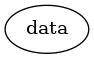

In [9]:
# Here we use a convenience method for linear DAGs.
dag.append_to_tail(node)
# At each stage in this notebook, we draw the DAG.
dtfcore.draw(dag)

In [10]:
# We specify which node to run "up to" and whether to run in "fit" or
#  "predict" mode.
# All nodes that are less than or equal to the specified node
#  (in the topological sense) are executed.
data_df = dag.run_leq_node("data", "fit")["df_out"]

run_leq_node:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# The data matches the input data.
# In this notebook, all data is processed at once. However, dataflow
#  supports the notion of a clock and supports running in an
#  incremental mode.
data_df.head()

ret_0                                     x_1                                     x_2                              
                 100       101       102       103       100       101       102       103       100       101       102       103
2023-05-01  0.330437 -0.377605 -0.982188 -0.094828  0.345584  2.117839  0.054102  0.876242  0.821618 -1.112021  0.272791  0.256486
2023-05-02  0.446375  0.663063 -0.466750 -2.250854 -1.303157  2.042772 -1.107373 -0.258848  0.905356  0.646703  0.199585  1.055743
2023-05-03  0.364572  0.167465 -1.648787 -1.425349 -0.536953 -0.514006  0.235506 -0.138655  0.581118 -1.648075  0.759520  0.033000
2023-05-04  0.546713 -0.683227 -0.297527  0.862445  0.294132  0.109014  0.254388  0.332814  0.028422 -1.227352  1.224647 -0.651281
2023-05-05 -0.482119 -0.098270  0.253447  1.218844 -0.736454 -0.072044 -0.810815 -0.125592 -0.162910 -0.944752  0.752244  0.669153

# Estimate model components

## Estimate beta

In [12]:
cols = data.columns.levels[0]
display(cols)
x_vars = list(cols.difference(["ret_0"]))
y_vars = ["ret_0"]

Index(['ret_0', 'x_1', 'x_2'], dtype='object')

In [13]:
# Use one of the dataflow nodes that wraps sklearn.
# This node
# - wraps supervised models
# - learns a model for each asset independently (we also have a wrapper
#   that pools across all assets)
# The "model_func" specifies which sklearn model to use.
# The sklearn model is configured through "model_kwargs", which are
#  forwarded to the model.
node_config = {
    "in_col_groups": [(x,) for x in cols],
    "out_col_group": (),
    "x_vars": x_vars,
    "y_vars": y_vars,
    "steps_ahead": 1,
    "model_func": slmode.LinearRegression,
    "model_kwargs": {
        "fit_intercept": False,
    },
    "nan_mode": "drop",
}
node = dtfcore.MultiindexSkLearnModel(
    "sklearn",
    **node_config,
)

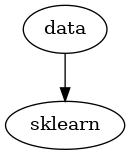

In [14]:
dag.append_to_tail(node)
dtfcore.draw(dag)

In [15]:
sklearn_df = dag.run_leq_node("sklearn", "fit")["df_out"]

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
sklearn_df.head()

ret_0.shift_-1                               ret_0.shift_-1_hat                                   ret_0                                     x_1                                     x_2                              
                      100       101       102       103                100       101       102       103       100       101       102       103       100       101       102       103       100       101       102       103
2023-05-01       0.446375  0.663063 -0.466750 -2.250854           0.039724 -0.003303  0.082740 -0.529041  0.330437 -0.377605 -0.982188 -0.094828  0.345584  2.117839  0.054102  0.876242  0.821618 -1.112021  0.272791  0.256486
2023-05-02       0.364572  0.167465 -1.648787 -1.425349           0.408234  0.329971 -1.242679 -1.199168  0.446375  0.663063 -0.466750 -2.250854 -1.303157  2.042772 -1.107373 -0.258848  0.905356  0.646703  0.199585  1.055743
2023-05-03       0.546713 -0.683227 -0.297527  0.862445           0.197211 -0.370850  0.326803 -0.004435  0.364572  0.167465 -1.648787 -1.425349 -0.536953 -0.514006  0.235506 -0.138655  0.581118 -1.648075  0.759520  0.033000
2023-05-04      -0.482119 -0.098270  0.253447  1.218844          -0.059698 -0.226907  0.384520  0.695936  0.546713 -0.683227 -0.297527  0.862445  0.294132  0.109014  0.254388  0.332814  0.028422 -1.227352  1.224647 -0.651281
2023-05-05      -0.292457 -0.506292 -1.481818 -1.514319           0.136685 -0.190286 -0.862632 -0.769797 -0.482119 -0.098270  0.253447  1.218844 -0.736454 -0.072044 -0.810815 -0.125592 -0.162910 -0.944752  0.752244  0.669153

## Estimate residual returns variances

In [17]:
sklearn_df.head()

ret_0.shift_-1                               ret_0.shift_-1_hat                                   ret_0                                     x_1                                     x_2                              
                      100       101       102       103                100       101       102       103       100       101       102       103       100       101       102       103       100       101       102       103
2023-05-01       0.446375  0.663063 -0.466750 -2.250854           0.039724 -0.003303  0.082740 -0.529041  0.330437 -0.377605 -0.982188 -0.094828  0.345584  2.117839  0.054102  0.876242  0.821618 -1.112021  0.272791  0.256486
2023-05-02       0.364572  0.167465 -1.648787 -1.425349           0.408234  0.329971 -1.242679 -1.199168  0.446375  0.663063 -0.466750 -2.250854 -1.303157  2.042772 -1.107373 -0.258848  0.905356  0.646703  0.199585  1.055743
2023-05-03       0.546713 -0.683227 -0.297527  0.862445           0.197211 -0.370850  0.326803 -0.004435  0.364572  0.167465 -1.648787 -1.425349 -0.536953 -0.514006  0.235506 -0.138655  0.581118 -1.648075  0.759520  0.033000
2023-05-04      -0.482119 -0.098270  0.253447  1.218844          -0.059698 -0.226907  0.384520  0.695936  0.546713 -0.683227 -0.297527  0.862445  0.294132  0.109014  0.254388  0.332814  0.028422 -1.227352  1.224647 -0.651281
2023-05-05      -0.292457 -0.506292 -1.481818 -1.514319           0.136685 -0.190286 -0.862632 -0.769797 -0.482119 -0.098270  0.253447  1.218844 -0.736454 -0.072044 -0.810815 -0.125592 -0.162910 -0.944752  0.752244  0.669153

In [18]:
# The sklearn modeling node does not automatically perform the
#  residualization. (We do have a different sklearn node that
#  learns a factor model (e.g., PCA) and automatically
#  residualizes.)
# Here we create a node to do the column arithmetic.
node_config = {
    "in_col_groups": [
        ("ret_0.shift_-1",), 
        ("ret_0.shift_-1_hat",),
    ],
    "out_col_group": (),
    "transformer_func": cofeatur.combine_columns,
    "transformer_kwargs": {
        "term1_col": "ret_0.shift_-1",
        "term2_col": "ret_0.shift_-1_hat",
        "out_col": "residual.shift_-1",
        "operation": "sub"
    }
}
node = dtfcore.GroupedColDfToDfTransformer(
    "residualize",
    **node_config,
)

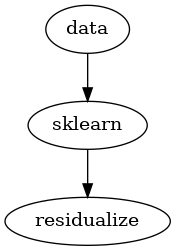

In [19]:
dag.append_to_tail(node)
dtfcore.draw(dag)

In [20]:
residualize_df = dag.run_leq_node("residualize", "fit")["df_out"]

run_leq_node:   0%|          | 0/3 [00:00<?, ?it/s]

/app/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [21]:
residualize_df.head()

residual.shift_-1                               ret_0.shift_-1                               ret_0.shift_-1_hat                                   ret_0                                     x_1                                     x_2                              
                         100       101       102       103            100       101       102       103                100       101       102       103       100       101       102       103       100       101       102       103       100       101       102       103
2023-05-01          0.406651  0.666367 -0.549490 -1.721813       0.446375  0.663063 -0.466750 -2.250854           0.039724 -0.003303  0.082740 -0.529041  0.330437 -0.377605 -0.982188 -0.094828  0.345584  2.117839  0.054102  0.876242  0.821618 -1.112021  0.272791  0.256486
2023-05-02         -0.043662 -0.162506 -0.406108 -0.226181       0.364572  0.167465 -1.648787 -1.425349           0.408234  0.329971 -1.242679 -1.199168  0.446375  0.663063 -0.466750 -2.250854 -1.303157  2.042772 -1.107373 -0.258848  0.905356  0.646703  0.199585  1.055743
2023-05-03          0.349502 -0.312376 -0.624330  0.866880       0.546713 -0.683227 -0.297527  0.862445           0.197211 -0.370850  0.326803 -0.004435  0.364572  0.167465 -1.648787 -1.425349 -0.536953 -0.514006  0.235506 -0.138655  0.581118 -1.648075  0.759520  0.033000
2023-05-04         -0.422422  0.128637 -0.131074  0.522907      -0.482119 -0.098270  0.253447  1.218844          -0.059698 -0.226907  0.384520  0.695936  0.546713 -0.683227 -0.297527  0.862445  0.294132  0.109014  0.254388  0.332814  0.028422 -1.227352  1.224647 -0.651281
2023-05-05         -0.429141 -0.316006 -0.619186 -0.744521      -0.292457 -0.506292 -1.481818 -1.514319           0.136685 -0.190286 -0.862632 -0.769797 -0.482119 -0.098270  0.253447  1.218844 -0.736454 -0.072044 -0.810815 -0.125592 -0.162910 -0.944752  0.752244  0.669153

In [22]:
# Next we use a simple EWMA to explicitly estimate the variances of the
#  residuals (though the sklearn model is internally computing this in
#  the regression).
node_config = {
    "in_col_group": ("residual.shift_-1",), 
    "out_col_group": ("smoothed_squared_residual.shift_-1",),
    "transformer_func": csigproc.compute_rolling_norm,
    "transformer_kwargs": {
        "tau": 10,
    }
}
node = dtfcore.SeriesToSeriesTransformer(
    "compute_rolling_norm",
    **node_config,
)

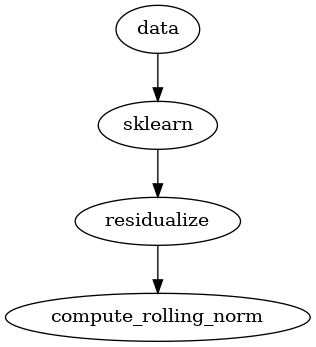

In [23]:
dag.append_to_tail(node)
dtfcore.draw(dag)

In [24]:
compute_rolling_norm_df = dag.run_leq_node(
    "compute_rolling_norm", "fit"
)["df_out"]

run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [25]:
compute_rolling_norm_df.head()

smoothed_squared_residual.shift_-1                               residual.shift_-1                               ret_0.shift_-1                               ret_0.shift_-1_hat                                   ret_0                                     x_1                                     x_2                              
                                          100       101       102       103               100       101       102       103            100       101       102       103                100       101       102       103       100       101       102       103       100       101       102       103       100       101       102       103
2023-05-01                           0.406651  0.666367  0.549490  1.721813          0.406651  0.666367 -0.549490 -1.721813       0.446375  0.663063 -0.466750 -2.250854           0.039724 -0.003303  0.082740 -0.529041  0.330437 -0.377605 -0.982188 -0.094828  0.345584  2.117839  0.054102  0.876242  0.821618 -1.112021  0.272791  0.256486
2023-05-02                           0.282050  0.474125  0.479592  1.197966         -0.043662 -0.162506 -0.406108 -0.226181       0.364572  0.167465 -1.648787 -1.425349           0.408234  0.329971 -1.242679 -1.199168  0.446375  0.663063 -0.466750 -2.250854 -1.303157  2.042772 -1.107373 -0.258848  0.905356  0.646703  0.199585  1.055743
2023-05-03                           0.308534  0.422001  0.537284  1.088170          0.349502 -0.312376 -0.624330  0.866880       0.546713 -0.683227 -0.297527  0.862445           0.197211 -0.370850  0.326803 -0.004435  0.364572  0.167465 -1.648787 -1.425349 -0.536953 -0.514006  0.235506 -0.138655  0.581118 -1.648075  0.759520  0.033000
2023-05-04                           0.345286  0.362570  0.458593  0.959814         -0.422422  0.128637 -0.131074  0.522907      -0.482119 -0.098270  0.253447  1.218844          -0.059698 -0.226907  0.384520  0.695936  0.546713 -0.683227 -0.297527  0.862445  0.294132  0.109014  0.254388  0.332814  0.028422 -1.227352  1.224647 -0.651281
2023-05-05                           0.367326  0.351874  0.502164  0.912414         -0.429141 -0.316006 -0.619186 -0.744521      -0.292457 -0.506292 -1.481818 -1.514319           0.136685 -0.190286 -0.862632 -0.769797 -0.482119 -0.098270  0.253447  1.218844 -0.736454 -0.072044 -0.810815 -0.125592 -0.162910 -0.944752  0.752244  0.669153

## Estimate factor returns variance-covariance matrices

In [26]:
# TODO: We can compute beta beta^transpose, linearizing the matrix as
#  feature columns, and then apply EWMA smoothing as above.

# Extract estimates and compute statistics

In [27]:
# Information supplementary to the dataframes can be accessed
# (such as any sklearn model info).
sklearn_fit_state = dag.get_node("sklearn").get_fit_state()
display(sklearn_fit_state.keys())

dict_keys(['_key_fit_state', "_info['fit']"])

In [28]:
# Note that we may recover from sklearn information such as
# - model coefficients
# - model score
# - full model specification
sklearn_fit_state["_key_fit_state"][100]

{'_model': LinearRegression(fit_intercept=False),
 "_info['fit']": OrderedDict([('model_x_vars', ['x_1', 'x_2']),
              ('model_params',
               {'copy_X': True,
                'fit_intercept': False,
                'n_jobs': None,
                'normalize': 'deprecated',
                'positive': False}),
              ('model_attributes',
               OrderedDict([('fit_intercept', False),
                            ('normalize', 'deprecated'),
                            ('copy_X', True),
                            ('n_jobs', None),
                            ('positive', False),
                            ('n_features_in_', 2),
                            ('coef_', array([[-0.21643078,  0.13938234]])),
                            ('rank_', 2),
                            ('singular_', array([3.67883457, 2.18353991])),
                            ('intercept_', 0.0)])),
              ('model_score', 0.07223187389865093),
              ('df_out_info',
     

# Alternative DAG construction method

In [29]:
# In transferring this DAG from a notebook to code, we would do something
# similar to the following:

class SimpleRiskModel_DagBuilder(dtfcore.DagBuilder):
    """
    A pipeline similar to real feature processing.
    """

    @staticmethod
    def get_column_name(tag: str) -> str:
        """
        See description in the parent class.
        """
        raise NotImplementedError

    def get_trading_period(
        self, config: cconfig.Config, mark_key_as_used: bool
    ) -> str:
        """
        See description in the parent class.
        """
        _ = self
        raise NotImplementedError

    def get_required_lookback_in_effective_days(
        self, config: cconfig.Config, mark_key_as_used: bool
    ) -> str:
        """
        See description in the parent class.
        """
        raise NotImplementedError

    def set_weights(
        self, config: cconfig.Config, weights: pd.Series
    ) -> cconfig.Config:
        """
        See description in the parent class.
        """
        raise NotImplementedError

    def convert_to_fast_prod_setup(
        self, config: cconfig.Config
    ) -> cconfig.Config:
        """
        See description in the parent class.
        """
        raise NotImplementedError

    def get_config_template(self) -> cconfig.Config:
        dict_ = {
            self._get_nid("sklearn"): {
                "in_col_groups": [(x,) for x in cols],
                "out_col_group": (),
                "x_vars": x_vars,
                "y_vars": y_vars,
                "steps_ahead": 1,
                "model_kwargs": {
                    "fit_intercept": False,
                },
                "nan_mode": "drop",
            },
            self._get_nid("residualize"): {
                "in_col_groups": [
                    ("ret_0.shift_-1",), 
                    ("ret_0.shift_-1_hat",),
                ],
                "out_col_group": (),
                "transformer_kwargs": {
                    "term1_col": "ret_0.shift_-1",
                    "term2_col": "ret_0.shift_-1_hat",
                    "out_col": "residual.shift_-1",
                    "operation": "sub"
                }
            },
            self._get_nid("compute_rolling_node"): {
                "in_col_group": ("residual.shift_-1",), 
                "out_col_group": ("smoothed_squared_residual.shift_-1",),
                "transformer_kwargs": {
                    "tau": 10,
                }
            },
        }
        config = cconfig.Config.from_dict(dict_)
        return config

    def _get_dag(
        self,
        config: cconfig.Config,
        mode: str = "strict",
    ) -> dtfcore.DAG:
        dag = dtfcore.DAG(mode=mode)
        _LOG.debug("%s", config)
        #
        stage = "sklearn"
        nid = self._get_nid(stage)
        node = dtfcore.MultiindexSkLearnModel(
            nid,
            model_func=slmode.LinearRegression,
            **config[nid].to_dict(),
        )
        dag.append_to_tail(node)
        #
        node = dtfcore.GroupedColDfToDfTransformer(
            "residualize",
            transformer_func=cofeatur.combine_columns,
            **config[nid].to_dict(),
        )
        dag.append_to_tail(node)
        #
        node = dtfcore.SeriesToSeriesTransformer(
            nid,
            transformer_func=csigproc.compute_rolling_norm,
            **config[nid].to_dict(),
        )
        dag.append_to_tail(node)
        #
        return dag